In [16]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from tqdm import tqdm
import seaborn as sns

# Theory

We have $$Q \sim \chi_k^2$$ when $$Q = \sum_{i=1}^n Z_i^2$$ where $$Z\sim \mathcal N(0,1)$$ 

## Formulation

We have our observation $X = {X_1, ...., X_n}$ as our data. 
Now our assumption is that $X_i \sim \mathcal N(\mu_i, \sigma_i^2)$. 

We want a model to learn to predict $\hat\mu_i, \hat\sigma_i^2$. 

So, let's consider the RV $Z_i = \frac{X_i-\hat \mu_i}{\hat\sigma_i^2}$, according to central limit theorem $Z_i \sim \mathcal N(0,1)$. Then we consider a RV $Q = \sum_{i=1}^K Z_i^2$ where $K$ is a hyperparameter.

Then we have that $Q\sim \chi^2_K$. And for $K > 50$ $\chi^2_K \rightarrow \mathcal N(K, 2K)$, hence $Q\sim N(K, 2K)$

### Loss Derivation

For the loss we use maximum liklihood of RV $Q$ to estimate parameters. So, $$L(\mathbf{\hat\mu}, \mathbf{\hat\sigma^2}) = -\prod_j^N p(Q_j|K) \\ = -\sum_j^N log p(Q_j|K) = - \sum_j^N \frac{-(Q_j-K)^2}{2K} - \log (2K) \\ = \frac{1}{2K}\sum_j^N (Q_j-K)^2 \\ = \frac{1}{2K}\sum_j^N (\sum_i^K \frac{(X_i-\hat\mu_i)^2}{\hat\sigma^2} -K)^2 $$

Note that we consider $K$ to be large here. 

## Experiment 1: Constant variance, Different means 

Here we have constant ground truth $\sigma_i^2 =1 \space \forall i$ and different mean $\mu_i \forall i \in {0,...N}$. Then we sample $X_i$ once from each of these $N$ normal distributions. This $X_i$ is our observations and our model will have access to it during training and not the ground truth means and variance. 

Our aim is to estimate each to these means and variance as $\hat\mu_i, \hat\sigma_i^2$


**Generating Training Data**

In [17]:
# N = 5000
num_samples = 5000

# \sigma_i^2 = 1
gt_var = 1

# \mu_i ~ N(0, 5^2 = 25)
gt_mu = np.random.normal(0,5, num_samples)

print("Mean: ", gt_mu)
print("Variance:", gt_var)

Mean:  [ 0.5228459   3.79263476 -0.52358763 ... -1.56418854 -3.29082158
  4.77050511]
Variance: 1


In [18]:
gt_observations = np.random.normal(gt_mu, gt_var)
gt_observations = torch.tensor(gt_observations)
print("Training data size:", len(gt_observations))

Training data size: 5000


In [19]:
print(gt_observations.mean(), gt_observations.var())


tensor(0.1406, dtype=torch.float64) tensor(26.5118, dtype=torch.float64)


**Training Procedure**

In [20]:
pred_mean = torch.ones(num_samples, requires_grad= True)
pred_var = torch.ones(num_samples, requires_grad = True)
# pred_var = torch.ones(1, requires_grad = True)

print(pred_mean, pred_var)

tensor([1., 1., 1.,  ..., 1., 1., 1.], requires_grad=True) tensor([1., 1., 1.,  ..., 1., 1., 1.], requires_grad=True)


In [21]:
learning_rate = 5e-2
optim = torch.optim.SGD([pred_mean, pred_var], lr = learning_rate)

# K = 50
deg_freedom = 50

batch_size = int(num_samples/deg_freedom)

In [22]:
num_epochs = 2000
for epoch in tqdm(range(num_epochs)):
    index = np.random.permutation(num_samples).reshape((batch_size, deg_freedom))
    
    chi_stat = ((pred_mean[index] - gt_observations[index])**2/pred_var[index]).sum(axis=1)
#     chi_stat = ((pred_mean[index] - gt_observations[index])**2/pred_var).sum(axis=1)
    # print(chi_stat.shape)

    batch_loss = ((chi_stat- deg_freedom)**2/(2*deg_freedom)).mean()
#     batch_loss = ((chi_stat- deg_freedom)**2/(2*deg_freedom)).sum()
    # print(batch_loss)

    optim.zero_grad()
    batch_loss.backward()
    optim.step()
    
    if epoch%5==0:
        print("Loss:, ", batch_loss)


 14%|█▍        | 287/2000 [00:00<00:01, 1366.99it/s]

Loss:,  tensor(18051.8190, dtype=torch.float64, grad_fn=<MeanBackward0>)
Loss:,  tensor(2743.3685, dtype=torch.float64, grad_fn=<MeanBackward0>)
Loss:,  tensor(1979.4288, dtype=torch.float64, grad_fn=<MeanBackward0>)
Loss:,  tensor(1572.0438, dtype=torch.float64, grad_fn=<MeanBackward0>)
Loss:,  tensor(1319.0150, dtype=torch.float64, grad_fn=<MeanBackward0>)
Loss:,  tensor(1141.4607, dtype=torch.float64, grad_fn=<MeanBackward0>)
Loss:,  tensor(998.6495, dtype=torch.float64, grad_fn=<MeanBackward0>)
Loss:,  tensor(890.7304, dtype=torch.float64, grad_fn=<MeanBackward0>)
Loss:,  tensor(805.9882, dtype=torch.float64, grad_fn=<MeanBackward0>)
Loss:,  tensor(734.6307, dtype=torch.float64, grad_fn=<MeanBackward0>)
Loss:,  tensor(675.2891, dtype=torch.float64, grad_fn=<MeanBackward0>)
Loss:,  tensor(623.8623, dtype=torch.float64, grad_fn=<MeanBackward0>)
Loss:,  tensor(581.2446, dtype=torch.float64, grad_fn=<MeanBackward0>)
Loss:,  tensor(542.3864, dtype=torch.float64, grad_fn=<MeanBackward0>)

 30%|███       | 607/2000 [00:00<00:00, 1476.25it/s]

tensor(111.8606, dtype=torch.float64, grad_fn=<MeanBackward0>)
Loss:,  tensor(109.3846, dtype=torch.float64, grad_fn=<MeanBackward0>)
Loss:,  tensor(106.1370, dtype=torch.float64, grad_fn=<MeanBackward0>)
Loss:,  tensor(104.2900, dtype=torch.float64, grad_fn=<MeanBackward0>)
Loss:,  tensor(101.4398, dtype=torch.float64, grad_fn=<MeanBackward0>)
Loss:,  tensor(100.4618, dtype=torch.float64, grad_fn=<MeanBackward0>)
Loss:,  tensor(97.3352, dtype=torch.float64, grad_fn=<MeanBackward0>)
Loss:,  tensor(94.9026, dtype=torch.float64, grad_fn=<MeanBackward0>)
Loss:,  tensor(92.7657, dtype=torch.float64, grad_fn=<MeanBackward0>)
Loss:,  tensor(92.6199, dtype=torch.float64, grad_fn=<MeanBackward0>)
Loss:,  tensor(89.2936, dtype=torch.float64, grad_fn=<MeanBackward0>)
Loss:,  tensor(88.1000, dtype=torch.float64, grad_fn=<MeanBackward0>)
Loss:,  tensor(86.3931, dtype=torch.float64, grad_fn=<MeanBackward0>)
Loss:,  tensor(84.5081, dtype=torch.float64, grad_fn=<MeanBackward0>)
Loss:,  tensor(84.9739

 47%|████▋     | 931/2000 [00:00<00:00, 1545.85it/s]

tensor(39.0948, dtype=torch.float64, grad_fn=<MeanBackward0>)
Loss:,  tensor(39.0199, dtype=torch.float64, grad_fn=<MeanBackward0>)
Loss:,  tensor(37.6536, dtype=torch.float64, grad_fn=<MeanBackward0>)
Loss:,  tensor(37.4278, dtype=torch.float64, grad_fn=<MeanBackward0>)
Loss:,  tensor(37.1104, dtype=torch.float64, grad_fn=<MeanBackward0>)
Loss:,  tensor(35.6912, dtype=torch.float64, grad_fn=<MeanBackward0>)
Loss:,  tensor(36.2532, dtype=torch.float64, grad_fn=<MeanBackward0>)
Loss:,  tensor(35.1485, dtype=torch.float64, grad_fn=<MeanBackward0>)
Loss:,  tensor(35.1881, dtype=torch.float64, grad_fn=<MeanBackward0>)
Loss:,  tensor(35.2001, dtype=torch.float64, grad_fn=<MeanBackward0>)
Loss:,  tensor(34.0049, dtype=torch.float64, grad_fn=<MeanBackward0>)
Loss:,  tensor(34.1764, dtype=torch.float64, grad_fn=<MeanBackward0>)
Loss:,  tensor(33.8522, dtype=torch.float64, grad_fn=<MeanBackward0>)
Loss:,  tensor(33.0371, dtype=torch.float64, grad_fn=<MeanBackward0>)
Loss:,  tensor(32.7834, dtyp

 63%|██████▎   | 1252/2000 [00:00<00:00, 1573.16it/s]

Loss:,  tensor(19.2743, dtype=torch.float64, grad_fn=<MeanBackward0>)
Loss:,  tensor(18.1655, dtype=torch.float64, grad_fn=<MeanBackward0>)
Loss:,  tensor(19.2589, dtype=torch.float64, grad_fn=<MeanBackward0>)
Loss:,  tensor(18.0061, dtype=torch.float64, grad_fn=<MeanBackward0>)
Loss:,  tensor(19.1551, dtype=torch.float64, grad_fn=<MeanBackward0>)
Loss:,  tensor(17.7362, dtype=torch.float64, grad_fn=<MeanBackward0>)
Loss:,  tensor(18.5482, dtype=torch.float64, grad_fn=<MeanBackward0>)
Loss:,  tensor(17.2855, dtype=torch.float64, grad_fn=<MeanBackward0>)
Loss:,  tensor(17.4339, dtype=torch.float64, grad_fn=<MeanBackward0>)
Loss:,  tensor(17.4453, dtype=torch.float64, grad_fn=<MeanBackward0>)
Loss:,  tensor(17.1597, dtype=torch.float64, grad_fn=<MeanBackward0>)
Loss:,  tensor(16.2098, dtype=torch.float64, grad_fn=<MeanBackward0>)
Loss:,  tensor(17.2341, dtype=torch.float64, grad_fn=<MeanBackward0>)
Loss:,  tensor(16.4041, dtype=torch.float64, grad_fn=<MeanBackward0>)
Loss:,  tensor(15.83

 70%|███████   | 1403/2000 [00:00<00:00, 1527.68it/s]

tensor(11.5639, dtype=torch.float64, grad_fn=<MeanBackward0>)
Loss:,  tensor(10.9382, dtype=torch.float64, grad_fn=<MeanBackward0>)
Loss:,  tensor(11.4033, dtype=torch.float64, grad_fn=<MeanBackward0>)
Loss:,  tensor(10.5829, dtype=torch.float64, grad_fn=<MeanBackward0>)
Loss:,  tensor(11.3020, dtype=torch.float64, grad_fn=<MeanBackward0>)
Loss:,  tensor(11.2799, dtype=torch.float64, grad_fn=<MeanBackward0>)
Loss:,  tensor(10.6343, dtype=torch.float64, grad_fn=<MeanBackward0>)
Loss:,  tensor(10.7718, dtype=torch.float64, grad_fn=<MeanBackward0>)
Loss:,  tensor(10.8032, dtype=torch.float64, grad_fn=<MeanBackward0>)
Loss:,  tensor(10.1801, dtype=torch.float64, grad_fn=<MeanBackward0>)
Loss:,  tensor(9.8937, dtype=torch.float64, grad_fn=<MeanBackward0>)
Loss:,  tensor(10.0325, dtype=torch.float64, grad_fn=<MeanBackward0>)
Loss:,  tensor(10.5279, dtype=torch.float64, grad_fn=<MeanBackward0>)
Loss:,  tensor(10.3543, dtype=torch.float64, grad_fn=<MeanBackward0>)
Loss:,  tensor(9.6931, dtype=

 85%|████████▍ | 1699/2000 [00:01<00:00, 1464.01it/s]

Loss:,  tensor(7.1771, dtype=torch.float64, grad_fn=<MeanBackward0>)
Loss:,  tensor(7.1287, dtype=torch.float64, grad_fn=<MeanBackward0>)
Loss:,  tensor(7.5187, dtype=torch.float64, grad_fn=<MeanBackward0>)
Loss:,  tensor(7.2034, dtype=torch.float64, grad_fn=<MeanBackward0>)
Loss:,  tensor(7.4244, dtype=torch.float64, grad_fn=<MeanBackward0>)
Loss:,  tensor(7.4875, dtype=torch.float64, grad_fn=<MeanBackward0>)
Loss:,  tensor(6.4318, dtype=torch.float64, grad_fn=<MeanBackward0>)
Loss:,  tensor(7.2759, dtype=torch.float64, grad_fn=<MeanBackward0>)
Loss:,  tensor(6.9160, dtype=torch.float64, grad_fn=<MeanBackward0>)
Loss:,  tensor(6.9516, dtype=torch.float64, grad_fn=<MeanBackward0>)
Loss:,  tensor(6.9917, dtype=torch.float64, grad_fn=<MeanBackward0>)
Loss:,  tensor(6.9300, dtype=torch.float64, grad_fn=<MeanBackward0>)
Loss:,  tensor(6.7048, dtype=torch.float64, grad_fn=<MeanBackward0>)
Loss:,  tensor(6.4135, dtype=torch.float64, grad_fn=<MeanBackward0>)
Loss:,  tensor(6.5895, dtype=torch

100%|██████████| 2000/2000 [00:01<00:00, 1514.55it/s]

Loss:,  tensor(5.2843, dtype=torch.float64, grad_fn=<MeanBackward0>)
Loss:,  tensor(5.3467, dtype=torch.float64, grad_fn=<MeanBackward0>)
Loss:,  tensor(5.6029, dtype=torch.float64, grad_fn=<MeanBackward0>)
Loss:,  tensor(4.8361, dtype=torch.float64, grad_fn=<MeanBackward0>)
Loss:,  tensor(5.2132, dtype=torch.float64, grad_fn=<MeanBackward0>)
Loss:,  tensor(4.9748, dtype=torch.float64, grad_fn=<MeanBackward0>)
Loss:,  tensor(5.3637, dtype=torch.float64, grad_fn=<MeanBackward0>)
Loss:,  tensor(5.2770, dtype=torch.float64, grad_fn=<MeanBackward0>)
Loss:,  tensor(4.8473, dtype=torch.float64, grad_fn=<MeanBackward0>)
Loss:,  tensor(5.0640, dtype=torch.float64, grad_fn=<MeanBackward0>)
Loss:,  tensor(4.7732, dtype=torch.float64, grad_fn=<MeanBackward0>)
Loss:,  tensor(4.7174, dtype=torch.float64, grad_fn=<MeanBackward0>)
Loss:,  tensor(5.3424, dtype=torch.float64, grad_fn=<MeanBackward0>)
Loss:,  tensor(4.8521, dtype=torch.float64, grad_fn=<MeanBackward0>)
Loss:,  tensor(4.9379, dtype=torch

In [23]:
print("Absolute Mean Error: ",(pred_mean.detach().numpy()-gt_mu).mean())
print("Absolute Variance Error: ", (pred_var.detach().numpy()-gt_var).mean())
print("Calibration Error: ", torch.abs((pred_mean-gt_observations)**2-pred_var).detach().numpy().mean())
print(pred_var)

Absolute Mean Error:  0.4296574721733183
Absolute Variance Error:  1.9434211
Calibration Error:  5.659149291990534
tensor([1.0035, 2.7691, 1.6696,  ..., 1.6190, 3.7187, 2.6810],
       requires_grad=True)


Mean:  0.1893334674902497 Var:  1.2883871296838985


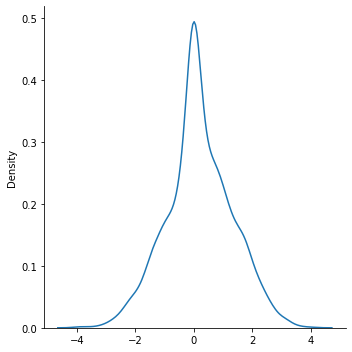

In [24]:
normalized_x = ((pred_mean-gt_observations)/torch.sqrt(pred_var)).detach().numpy()
print("Mean: ", normalized_x.mean(), "Var: ", normalized_x.var())
sns.displot(normalized_x, kind="kde")
plt.show()


We see that the variable $Z = \frac{x-\mu}{\sigma}$ really follows $\mathcal N(0.23,1.27)$. Which is very close to $\mathcal N(0,1)$, where this minor difference can be due to approximation of $\chi_K^2 \approx \mathcal N(K, 2K)$

## Which shows that using chi-sqaure loss works.

### -------------------------------------------------xxxxxxxxxxxxxx---------------------------------------------------------


## Experiment 2: Different variance, Different means 

Here we have different ground truth $\sigma_i \sim U(1,2)$ and different mean $\mu_i \sim \mathcal N(0,25)$. Then we sample $X_i$ once from each of these $N$ normal distributions. This $X_i$ is our observations and our model will have access to it during training and not the ground truth means and variance. 

Our aim is to estimate each to these means and variance as $\hat\mu_i, \hat\sigma_i^2$


**Generating Training Data**

In [250]:
# N = 5000
num_samples = 5000

# \sigma_i^2 = 1
gt_var = np.random.uniform(1,2, num_samples)**2

# \mu_i ~ N(0, 5^2 = 25)
gt_mu = np.random.normal(0,5, num_samples)

print("Mean: ", gt_mu)
print("Variance:", gt_var)

Mean:  [ 3.64676011  5.18606202 -6.3598712  ... -0.53714615 -6.3228859
  0.59822228]
Variance: [2.6794792  3.25666612 3.93005144 ... 3.85655768 2.51291954 3.0096082 ]


In [251]:
gt_observations = np.random.normal(gt_mu, gt_var)
gt_observations = torch.tensor(gt_observations)
print("Training data size:", len(gt_observations))

Training data size: 5000


In [253]:
print(gt_observations.mean(), gt_observations.var())


tensor(0.0972, dtype=torch.float64) tensor(31.8513, dtype=torch.float64)


**Training Procedure**

In [254]:
pred_mean = torch.ones(num_samples, requires_grad= True)
pred_var = torch.ones(num_samples, requires_grad = True)
# pred_var = torch.ones(1, requires_grad = True)

print(pred_mean, pred_var)

tensor([1., 1., 1.,  ..., 1., 1., 1.], requires_grad=True) tensor([1., 1., 1.,  ..., 1., 1., 1.], requires_grad=True)


In [255]:
learning_rate = 5e-2
optim = torch.optim.SGD([pred_mean, pred_var], lr = learning_rate)

# K = 50
deg_freedom = 50

batch_size = int(num_samples/deg_freedom)

In [256]:
num_epochs = 2000
for epoch in tqdm(range(num_epochs)):
    index = np.random.permutation(num_samples).reshape((batch_size, deg_freedom))
    
    chi_stat = ((pred_mean[index] - gt_observations[index])**2/pred_var[index]).sum(axis=1)
#     chi_stat = ((pred_mean[index] - gt_observations[index])**2/pred_var).sum(axis=1)
    # print(chi_stat.shape)

    batch_loss = ((chi_stat- deg_freedom)**2/(2*deg_freedom)).mean()
#     batch_loss = ((chi_stat- deg_freedom)**2/(2*deg_freedom)).sum()
    # print(batch_loss)

    optim.zero_grad()
    batch_loss.backward()
    optim.step()
    
    if epoch%5==0:
        print("Loss:, ", batch_loss)


 14%|█▍        | 276/2000 [00:00<00:01, 1292.57it/s]

Loss:,  tensor(26161.5974, dtype=torch.float64, grad_fn=<MeanBackward0>)
Loss:,  tensor(3044.5573, dtype=torch.float64, grad_fn=<MeanBackward0>)
Loss:,  tensor(2244.0592, dtype=torch.float64, grad_fn=<MeanBackward0>)
Loss:,  tensor(1823.8228, dtype=torch.float64, grad_fn=<MeanBackward0>)
Loss:,  tensor(1546.1671, dtype=torch.float64, grad_fn=<MeanBackward0>)
Loss:,  tensor(1333.2079, dtype=torch.float64, grad_fn=<MeanBackward0>)
Loss:,  tensor(1176.4555, dtype=torch.float64, grad_fn=<MeanBackward0>)
Loss:,  tensor(1058.9339, dtype=torch.float64, grad_fn=<MeanBackward0>)
Loss:,  tensor(960.9378, dtype=torch.float64, grad_fn=<MeanBackward0>)
Loss:,  tensor(872.0375, dtype=torch.float64, grad_fn=<MeanBackward0>)
Loss:,  tensor(811.7616, dtype=torch.float64, grad_fn=<MeanBackward0>)
Loss:,  tensor(745.6656, dtype=torch.float64, grad_fn=<MeanBackward0>)
Loss:,  tensor(694.6853, dtype=torch.float64, grad_fn=<MeanBackward0>)
Loss:,  tensor(647.3277, dtype=torch.float64, grad_fn=<MeanBackward0

 30%|██▉       | 592/2000 [00:00<00:00, 1423.48it/s]

Loss:,  tensor(145.0517, dtype=torch.float64, grad_fn=<MeanBackward0>)
Loss:,  tensor(139.9036, dtype=torch.float64, grad_fn=<MeanBackward0>)
Loss:,  tensor(139.1275, dtype=torch.float64, grad_fn=<MeanBackward0>)
Loss:,  tensor(135.2900, dtype=torch.float64, grad_fn=<MeanBackward0>)
Loss:,  tensor(133.3670, dtype=torch.float64, grad_fn=<MeanBackward0>)
Loss:,  tensor(129.4272, dtype=torch.float64, grad_fn=<MeanBackward0>)
Loss:,  tensor(127.5204, dtype=torch.float64, grad_fn=<MeanBackward0>)
Loss:,  tensor(123.4538, dtype=torch.float64, grad_fn=<MeanBackward0>)
Loss:,  tensor(124.4710, dtype=torch.float64, grad_fn=<MeanBackward0>)
Loss:,  tensor(120.5179, dtype=torch.float64, grad_fn=<MeanBackward0>)
Loss:,  tensor(117.7319, dtype=torch.float64, grad_fn=<MeanBackward0>)
Loss:,  tensor(116.2633, dtype=torch.float64, grad_fn=<MeanBackward0>)
Loss:,  tensor(110.7969, dtype=torch.float64, grad_fn=<MeanBackward0>)
Loss:,  tensor(109.4066, dtype=torch.float64, grad_fn=<MeanBackward0>)
Loss:,

 46%|████▌     | 912/2000 [00:00<00:00, 1508.51it/s]

tensor(51.7771, dtype=torch.float64, grad_fn=<MeanBackward0>)
Loss:,  tensor(50.1501, dtype=torch.float64, grad_fn=<MeanBackward0>)
Loss:,  tensor(49.9383, dtype=torch.float64, grad_fn=<MeanBackward0>)
Loss:,  tensor(50.5074, dtype=torch.float64, grad_fn=<MeanBackward0>)
Loss:,  tensor(49.5637, dtype=torch.float64, grad_fn=<MeanBackward0>)
Loss:,  tensor(48.0581, dtype=torch.float64, grad_fn=<MeanBackward0>)
Loss:,  tensor(47.3962, dtype=torch.float64, grad_fn=<MeanBackward0>)
Loss:,  tensor(48.7493, dtype=torch.float64, grad_fn=<MeanBackward0>)
Loss:,  tensor(46.9922, dtype=torch.float64, grad_fn=<MeanBackward0>)
Loss:,  tensor(45.5746, dtype=torch.float64, grad_fn=<MeanBackward0>)
Loss:,  tensor(45.1597, dtype=torch.float64, grad_fn=<MeanBackward0>)
Loss:,  tensor(44.9970, dtype=torch.float64, grad_fn=<MeanBackward0>)
Loss:,  tensor(45.3132, dtype=torch.float64, grad_fn=<MeanBackward0>)
Loss:,  tensor(44.7337, dtype=torch.float64, grad_fn=<MeanBackward0>)
Loss:,  tensor(43.1584, dtyp

 62%|██████▏   | 1237/2000 [00:00<00:00, 1565.84it/s]

Loss:,  tensor(25.3678, dtype=torch.float64, grad_fn=<MeanBackward0>)
Loss:,  tensor(25.1142, dtype=torch.float64, grad_fn=<MeanBackward0>)
Loss:,  tensor(25.2611, dtype=torch.float64, grad_fn=<MeanBackward0>)
Loss:,  tensor(25.1231, dtype=torch.float64, grad_fn=<MeanBackward0>)
Loss:,  tensor(24.9545, dtype=torch.float64, grad_fn=<MeanBackward0>)
Loss:,  tensor(24.9804, dtype=torch.float64, grad_fn=<MeanBackward0>)
Loss:,  tensor(24.7708, dtype=torch.float64, grad_fn=<MeanBackward0>)
Loss:,  tensor(23.8539, dtype=torch.float64, grad_fn=<MeanBackward0>)
Loss:,  tensor(23.7407, dtype=torch.float64, grad_fn=<MeanBackward0>)
Loss:,  tensor(23.1653, dtype=torch.float64, grad_fn=<MeanBackward0>)
Loss:,  tensor(22.6769, dtype=torch.float64, grad_fn=<MeanBackward0>)
Loss:,  tensor(23.0373, dtype=torch.float64, grad_fn=<MeanBackward0>)
Loss:,  tensor(23.0033, dtype=torch.float64, grad_fn=<MeanBackward0>)
Loss:,  tensor(23.7179, dtype=torch.float64, grad_fn=<MeanBackward0>)
Loss:,  tensor(22.56

 78%|███████▊  | 1551/2000 [00:01<00:00, 1558.56it/s]

Loss:,  tensor(15.6954, dtype=torch.float64, grad_fn=<MeanBackward0>)
Loss:,  tensor(14.7864, dtype=torch.float64, grad_fn=<MeanBackward0>)
Loss:,  tensor(15.3956, dtype=torch.float64, grad_fn=<MeanBackward0>)
Loss:,  tensor(14.4113, dtype=torch.float64, grad_fn=<MeanBackward0>)
Loss:,  tensor(15.0440, dtype=torch.float64, grad_fn=<MeanBackward0>)
Loss:,  tensor(14.4801, dtype=torch.float64, grad_fn=<MeanBackward0>)
Loss:,  tensor(14.9643, dtype=torch.float64, grad_fn=<MeanBackward0>)
Loss:,  tensor(13.6349, dtype=torch.float64, grad_fn=<MeanBackward0>)
Loss:,  tensor(13.7751, dtype=torch.float64, grad_fn=<MeanBackward0>)
Loss:,  tensor(13.7276, dtype=torch.float64, grad_fn=<MeanBackward0>)
Loss:,  tensor(13.9320, dtype=torch.float64, grad_fn=<MeanBackward0>)
Loss:,  tensor(14.1282, dtype=torch.float64, grad_fn=<MeanBackward0>)
Loss:,  tensor(12.8759, dtype=torch.float64, grad_fn=<MeanBackward0>)
Loss:,  tensor(13.1616, dtype=torch.float64, grad_fn=<MeanBackward0>)
Loss:,  tensor(13.49

 85%|████████▌ | 1705/2000 [00:01<00:00, 1489.80it/s]

Loss:,  tensor(9.4113, dtype=torch.float64, grad_fn=<MeanBackward0>)
Loss:,  tensor(10.0642, dtype=torch.float64, grad_fn=<MeanBackward0>)
Loss:,  tensor(10.0709, dtype=torch.float64, grad_fn=<MeanBackward0>)
Loss:,  tensor(10.1125, dtype=torch.float64, grad_fn=<MeanBackward0>)
Loss:,  tensor(9.0711, dtype=torch.float64, grad_fn=<MeanBackward0>)
Loss:,  tensor(9.1869, dtype=torch.float64, grad_fn=<MeanBackward0>)
Loss:,  tensor(9.7414, dtype=torch.float64, grad_fn=<MeanBackward0>)
Loss:,  tensor(9.4204, dtype=torch.float64, grad_fn=<MeanBackward0>)
Loss:,  tensor(9.0034, dtype=torch.float64, grad_fn=<MeanBackward0>)
Loss:,  tensor(8.9528, dtype=torch.float64, grad_fn=<MeanBackward0>)
Loss:,  tensor(9.6041, dtype=torch.float64, grad_fn=<MeanBackward0>)
Loss:,  tensor(9.1575, dtype=torch.float64, grad_fn=<MeanBackward0>)
Loss:,  tensor(9.0180, dtype=torch.float64, grad_fn=<MeanBackward0>)
Loss:,  tensor(9.5416, dtype=torch.float64, grad_fn=<MeanBackward0>)
Loss:,  tensor(8.8437, dtype=to

100%|██████████| 2000/2000 [00:01<00:00, 1511.20it/s]

Loss:,  tensor(7.1265, dtype=torch.float64, grad_fn=<MeanBackward0>)
Loss:,  tensor(6.6782, dtype=torch.float64, grad_fn=<MeanBackward0>)
Loss:,  tensor(6.5342, dtype=torch.float64, grad_fn=<MeanBackward0>)
Loss:,  tensor(6.7936, dtype=torch.float64, grad_fn=<MeanBackward0>)
Loss:,  tensor(7.0428, dtype=torch.float64, grad_fn=<MeanBackward0>)
Loss:,  tensor(7.0179, dtype=torch.float64, grad_fn=<MeanBackward0>)
Loss:,  tensor(6.6734, dtype=torch.float64, grad_fn=<MeanBackward0>)
Loss:,  tensor(6.2766, dtype=torch.float64, grad_fn=<MeanBackward0>)
Loss:,  tensor(6.2757, dtype=torch.float64, grad_fn=<MeanBackward0>)
Loss:,  tensor(6.3073, dtype=torch.float64, grad_fn=<MeanBackward0>)
Loss:,  tensor(7.5671, dtype=torch.float64, grad_fn=<MeanBackward0>)
Loss:,  tensor(6.5072, dtype=torch.float64, grad_fn=<MeanBackward0>)
Loss:,  tensor(6.3472, dtype=torch.float64, grad_fn=<MeanBackward0>)
Loss:,  tensor(5.9894, dtype=torch.float64, grad_fn=<MeanBackward0>)
Loss:,  tensor(6.1214, dtype=torch

In [257]:
print("Absolute Mean Error: ",(pred_mean.detach().numpy()-gt_mu).mean())
print("Absolute Variance Error: ", (pred_var.detach().numpy()-gt_var).mean())
print("Calibration Error: ", torch.abs((pred_mean-gt_observations)**2-pred_var).detach().numpy().mean())
print(pred_var)

Absolute Mean Error:  0.45330112175955584
Absolute Variance Error:  0.8769886359977384
Calibration Error:  6.811064719530656
tensor([2.6755, 2.8168, 8.9796,  ..., 1.5852, 5.5392, 1.6911],
       requires_grad=True)


Mean:  0.1855100584549643 Var:  1.3610111741504927


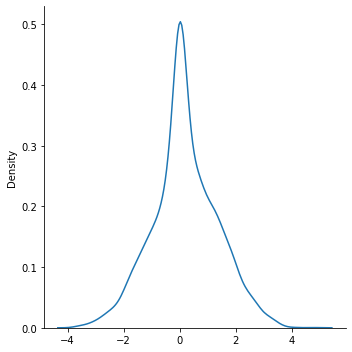

In [258]:
normalized_x = ((pred_mean-gt_observations)/torch.sqrt(pred_var)).detach().numpy()
print("Mean: ", normalized_x.mean(), "Var: ", normalized_x.var())
sns.displot(normalized_x, kind="kde")
plt.show()


We see that the variable $Z = \frac{x-\mu}{\sigma}$ really follows $\mathcal N(0.18,1.36)$. Which is very close to $\mathcal N(0,1)$, where this minor difference can be due to approximation of $\chi_K^2 \approx \mathcal N(K, 2K)$

## Which shows that using chi-sqaure loss works.